# K vecinos más cercanos (K Nearest Neighbors)

En este notebook estudiaremos cómo utilizar el clasificador k-NN de scikit-learn y distintas formas de medir su funcionamiento.

## Conjunto de datos

Usaremos un conjunto de datos sobre cáncer de mama en el que se usan 30 variables, extraídas a partir de imágenes, para tratar de predecir si la paciente tiene o no la enfermedad.

In [2]:
from sklearn.datasets import load_breast_cancer

breast = load_breast_cancer()

print('Names of the features:', breast['feature_names'])
print('Names of classes:', breast['target_names'])
print('Number of instances and features:', breast['data'].shape)

Names of the features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Names of classes: ['malignant' 'benign']
Number of instances and features: (569, 30)


In [3]:
import pandas as pd

# Crear tabla y añadir una columna con la clase que se trata de predecir
df = pd.DataFrame(data=breast['data'], columns=breast['feature_names']) 
df['result'] = breast['target']

df.head() # Sólo mostramos las primeras filas

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,result
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
# Frecuencia de las clases
df['result'].value_counts() / df['result'].count() * 100

1    62.741652
0    37.258348
Name: result, dtype: float64

En este caso la clase 'maligna' es más frecuente que la benigna (aprox. 2/3 frente a 1/3)

## Normalización de los datos

Las variables de este conjunto de datos son numéricas pero de una escala muy diferente por lo que para usar determinadas técnicas (como las basadas en distancia, como el k-NN, y en regresión de variables, como las redes neuronales) suele ser conveniente re-escalar los datos. 

In [5]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,result
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [6]:
from sklearn.preprocessing import StandardScaler

# Normalizamos los datos con StardardScaler que resta a cada variable su media y la divide
# entre su desviación típica.
# Otra opción sería usar MinMaxScaler que cambia el rango de la variable al intervalo [0,1]
scaler = StandardScaler()
scaler.fit(breast.data)
breast['data_scaled'] = scaler.transform(breast.data) # Lo almacenamos en el dataset original

In [7]:
# Creamos un nuevo dataframe
df_scaled = pd.DataFrame(data=breast['data_scaled'], columns=breast['feature_names'])
df_scaled['result'] = breast['target']
df_scaled.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,result
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,569.000000
mean,-3.162867e-15,-6.530609e-15,-7.078891e-16,-8.799835e-16,6.132177e-15,-1.120369e-15,-4.421380e-16,9.732500e-16,-1.971670e-15,-1.453631e-15,...,1.763674e-15,-1.198026e-15,5.049661e-16,-5.213170e-15,-2.174788e-15,6.856456e-16,-1.412656e-16,-2.289567e-15,2.575171e-15,0.627417
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,0.483918
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00,0.000000
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01,0.000000
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01,1.000000
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01,1.000000
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00,1.000000


## Conjuntos de entrenamiento y prueba

Podemos utilizar distintas técnicas para medir el funcionamiento de un clasificador (train/test split, leave one out, cross validation, ...). Una de las técnicas más habituales consiste en dividir el conjunto de datos en dos partes: entrenamiento y prueba. Entrenamos el clasificador con el conjunto de entrenamiento y probamos su funcionamiento con el conjunto de prueba. __Es muy importante que las métricas de clasificación se midan sobre un conjunto de datos distinto del que se usó para entrenar al clasificador__.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Como la proporción de clases a predecir está desbalanceada (2/3 y 1/3) es importante
# usar la versión estratificada que mantiene la proporción de elementos de cada clase 
# al hacer la partición
# En este caso usamos el 80% de instancias como conjunto de entrenamiento y el 20% como
# conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(breast.data_scaled, breast.target, 
                                                    test_size=0.20, stratify=breast.target)

# Creamos el clasificador k-NN
# Podemos fijar los pesos como 'uniform' o inv. proporcionales a la distancia 'distance'
clf = KNeighborsClassifier(n_neighbors=3, weights='distance')

# Entrenar el clasificador
clf.fit(X_train, y_train)

train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

train_accuracy, test_accuracy

(1.0, 0.956140350877193)

El valor de accuracy para el conjunto de entrenamiento siempre es más alto que para el conjunto de prueba (¡al final y al cabo estamos prediciendo datos que se han usado para entrenar el modelo!). De hecho, en el caso de k-NN siempre será del 100% porque el algoritmo almacena todos los datos de entrenamiento. __Siempre debemos calcular las métricas sobre el conjunto de prueba__ si queremos obtener valores reales sobre el funcionamiento del clasificador. 

## Matriz de confusión

La matriz de confusión nos permite ver el número de instancias real de cada clase y el número de instancias predichas por el clasificador. Permite comprobar fácilmente las clases que el clasificador confunde con mayor frecuencia.

Las filas de la matriz muestran el número de instancias reales de cada clase. Las columnas de la matriz muestran el número de instancias predichas por el clasificador en cada clase. Los elementos de la diagonal son los que se han predicho correctamente. 

In [22]:
from sklearn.metrics import confusion_matrix

y_test_predicted =clf.predict(X_test)
                            
confusion_matrix(y_test, y_test_predicted)

array([[38,  4],
       [ 1, 71]], dtype=int64)

A continuación usamos una función auxiliar para pintan la matriz de confusión en forma de gráfica.

In [23]:
# Función extraída de
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Normalized confusion matrix
[[0.9047619  0.0952381 ]
 [0.01388889 0.98611111]]


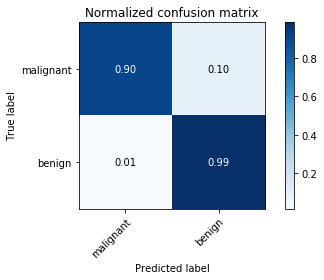

In [24]:
# El parámetro normalize permite mostrar los porcentajes en lugar del número de instancias
plot_confusion_matrix(y_test, y_test_predicted, breast.target_names, normalize=True)

## Validación cruzada

La técnica de validación cruzada nos permite obtener métricas sobre el comportamiento de un clasificador mucho más representativas de su funcionamiento real. Se divide el conjunto de datos en K partes y se entrena el clasificador K veces usando cada vez una parte distinta como conjunto de prueba (y el resto como conjunto de entrenamiento). Las métricas sobre el funcionamiento del clasificador se obtienen calculando la media de las obtenidas en las K iteraciones.

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

__Nota: no confundir la K de la validación cruzada con la K de los vecinos más cercanos, son variables distintas__.

In [25]:
from sklearn.model_selection import cross_validate
import numpy as np

# Creamos el clasificador k-NN
clf = KNeighborsClassifier(n_neighbors=3, weights='distance')

# Validación cruzada dividiendo el conjunto de datos en 5 partes (folds)
# cross_validate usa validación estratificada para problemas de clasificación binaria o multiclase
scores = cross_validate(clf, breast.data_scaled, breast.target, scoring='accuracy', 
                        cv=5, return_train_score=False)

# scores es un diccionario con datos sobre tiempos y exactitud (accuracy)
scores

{'fit_time': array([0.        , 0.00500798, 0.0050478 , 0.        , 0.0045042 ]),
 'score_time': array([0.01012778, 0.        , 0.00500536, 0.00505519, 0.        ]),
 'test_score': array([0.97391304, 0.95652174, 0.98230088, 0.94690265, 0.92920354])}

In [26]:
print('Accuracy mean:', np.mean(scores['test_score']))
print('Accuracy std:', np.std(scores['test_score']))

Accuracy mean: 0.9577683724509427
Accuracy std: 0.018963449837437595


## Seleccionando el valor de k para k-NN

Podemos seleccionar el valor óptimo de vecinos más cercanos usando validación cruzada con distintos valores de k.

In [17]:
# Medias y desviaciones típicas de accuracy para distintos valores de k
accuracy_mean = []
accuracy_std = []

k_values = range(1,15)
for k in k_values: 
    # Entrenar y validar
    clf = KNeighborsClassifier(k, weights='distance')
    scores = cross_validate(clf, breast.data_scaled, breast.target, scoring='accuracy', cv=10)
    
    accuracy_mean.append(np.mean(scores['test_score']))
    accuracy_std.append(np.std(scores['test_score']))
    
accuracy_mean

[0.950745397977703,
 0.950745397977703,
 0.9647523982369716,
 0.9647523982369718,
 0.9665694408434881,
 0.9647837265577737,
 0.9683551551292023,
 0.966569440843488,
 0.9649079595540575,
 0.968448059804684,
 0.9684480598046841,
 0.9649079595540575,
 0.966693673839772,
 0.9631222452683433]

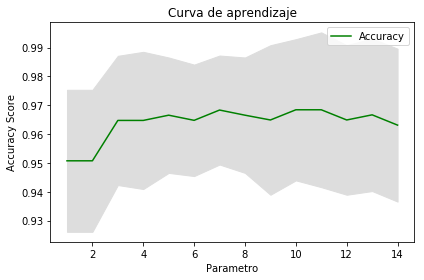

In [18]:
# Dibujamos la línea con la accuracy (exactitud) en el test
plt.plot(k_values, accuracy_mean, color="g", label="Accuracy")

# Dibujamos la banda de la desviación típica
lower_limit = np.array(accuracy_mean) - np.array(accuracy_std)
upper_limit = np.array(accuracy_mean) + np.array(accuracy_std)
plt.fill_between(k_values, lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

¿Qué valor de k seleccionarías a la vista de los resultados?